# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer pandas sklearn scikit-learn ipywidgets

## Import Libraries

In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

from vit_pytorch.efficient import ViT
from convert_pilimage_to_onehot import convert_pilimage_to_onehot


In [4]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1


In [5]:
# Training settings
batch_size = 64
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
#device = 'cpu'
device = 'mps'
#device = 'cuda'

## Load Data

In [8]:
os.makedirs('data', exist_ok=True)

In [9]:
with zipfile.ZipFile('tasks.zip') as tasks_zip:
    tasks_zip.extractall('data')

In [10]:
train_list = glob.glob('data/tasks/**/train/*.png', recursive=True)
test_list = glob.glob('data/tasks/**/test/*.png', recursive=True)

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 60967
Test Data: 7885


In [12]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

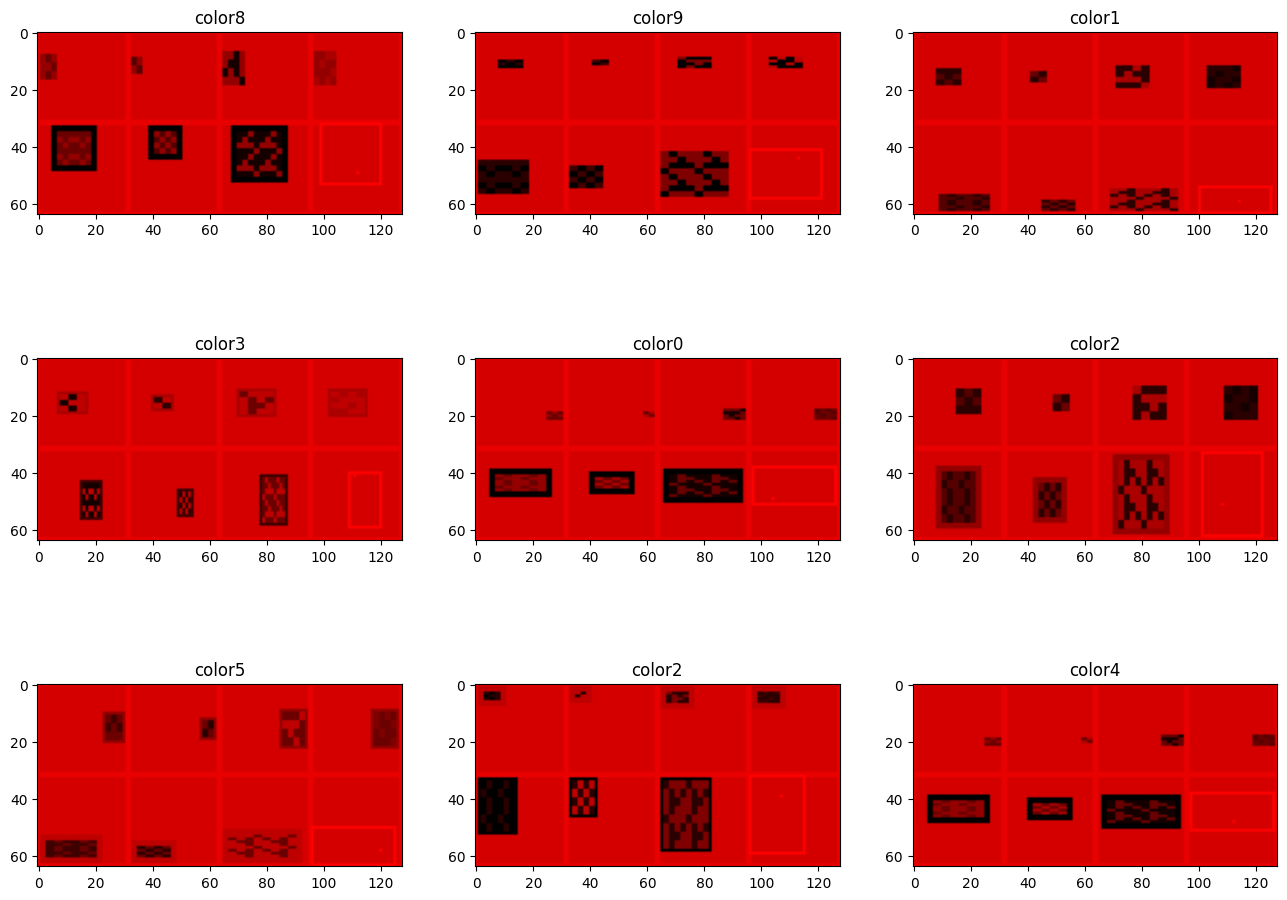

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 48773
Validation Data: 12194
Test Data: 7885


## Image Augmentation

In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
    ]
)


## Load Datasets

In [17]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #img_transformed = self.transform(img)
        img_transformed1 = self.transform(img)
        img_transformed2 = convert_pilimage_to_onehot(img_transformed1)
        img_transformed3 = img_transformed2.transpose(2, 0, 1)
        img_transformed = torch.from_numpy(img_transformed3.astype(np.float32))
        #print("shape a:", img_transformed.shape)

        raw_label = img_path.split("/")[-1].split(".")[0]
        label = 0
        if raw_label == "color0":
            label = 0
        if raw_label == "color1":
            label = 1
        if raw_label == "color2":
            label = 2
        if raw_label == "color3":
            label = 3
        if raw_label == "color4":
            label = 4
        if raw_label == "color5":
            label = 5
        if raw_label == "color6":
            label = 6
        if raw_label == "color7":
            label = 7
        if raw_label == "color8":
            label = 8
        if raw_label == "color9":
            label = 9
            
        return img_transformed, label


In [18]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))

48773 763


In [21]:
print(len(valid_data), len(valid_loader))

12194 191


## Efficient Attention

### Linformer

In [22]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [23]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer=efficient_transformer,
    channels=13,
).to(device)

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [46]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:22<00:00,  2.91it/s]


Epoch : 1 - loss : 1.0637 - acc: 0.5212 - val_loss : 1.0343 - val_acc: 0.5273



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:26<00:00,  2.87it/s]


Epoch : 2 - loss : 1.0655 - acc: 0.5190 - val_loss : 1.0570 - val_acc: 0.5226



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:38<00:00,  2.74it/s]


Epoch : 3 - loss : 1.0649 - acc: 0.5196 - val_loss : 1.0503 - val_acc: 0.5220



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:29<00:00,  2.83it/s]


Epoch : 4 - loss : 1.0646 - acc: 0.5186 - val_loss : 1.0550 - val_acc: 0.5238



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:36<00:00,  2.76it/s]


Epoch : 5 - loss : 1.0631 - acc: 0.5187 - val_loss : 1.0485 - val_acc: 0.5279



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:46<00:00,  2.67it/s]


Epoch : 6 - loss : 1.0639 - acc: 0.5185 - val_loss : 1.0517 - val_acc: 0.5217



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [05:04<00:00,  2.51it/s]


Epoch : 7 - loss : 1.0647 - acc: 0.5199 - val_loss : 1.0438 - val_acc: 0.5276



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [05:16<00:00,  2.41it/s]


Epoch : 8 - loss : 1.0632 - acc: 0.5203 - val_loss : 1.0627 - val_acc: 0.5186



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:37<00:00,  2.75it/s]


Epoch : 9 - loss : 1.0651 - acc: 0.5200 - val_loss : 1.0526 - val_acc: 0.5183



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [04:38<00:00,  2.74it/s]


Epoch : 10 - loss : 1.0600 - acc: 0.5204 - val_loss : 1.0460 - val_acc: 0.5220



In [38]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [37]:
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
state = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, 'checkpoint.pt')

In [25]:
checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

In [28]:
#optimizer
#model

In [48]:
import arc_json_model as ajm
from visualize import ajm_image_show
import export_task_to_image as etti
from pil_image_from_pixels import pil_image_from_pixels_with_red_palette
from simple_image import image_new, set_pixel, draw_rect, draw_box

ajm.Image.show = ajm_image_show

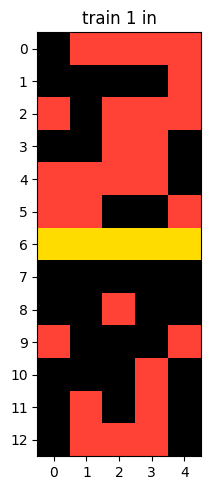

In [57]:
#filename = 'testdata/0520fde7.json'
#filename = 'testdata/23581191.json'
#filename = 'testdata/281123b4.json'
filename = 'testdata/3428a4f5.json'
#filename = 'testdata/48131b3c.json'
#filename = 'testdata/a59b95c0.json'
#filename = 'testdata/af902bf9.json'
#filename = 'testdata/cf98881b.json'
#filename = 'testdata/f2829549.json'
task = ajm.Task.load(filename)
image = task.pairs[1].input
image.show()

output size:  5 6


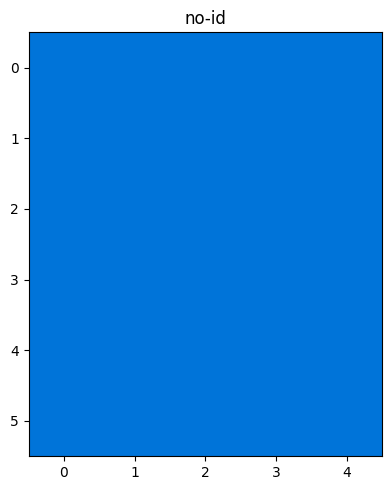

In [58]:
exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)

        img_transformed1 = test_transforms(pil_image)
        img_transformed2 = convert_pilimage_to_onehot(img_transformed1)
        img_transformed3 = img_transformed2.transpose(2, 0, 1)
        tensor = torch.from_numpy(img_transformed3.astype(np.float32))
        
        #tensor = test_transforms(pil_image)
        tensor = tensor[None, :]
        #if x == 2 and y == 2:
            #pil_image.show()
            #print(tensor.shape)

        data = tensor.to(device)
        output = model(data)
        #print(output)
        output_tensor = output.cpu().detach()
        #print(output_tensor)
        output_value = output_tensor.argmax(dim=1)
        #output_value = output_tensor.argmax(dim=None)
        #print(output_value)
        #result_pixels
        set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()

In [125]:
class SingleImageDataset(Dataset):
    def __init__(self, single_image: Image, transform=None):
        self.single_image = single_image
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = self.single_image.copy()
        if self.transform:
            image = self.transform(image)
        label = 42
        return image, label

output size:  4 4
x, y 0 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 2
tensor([[ 0.1438,  0.

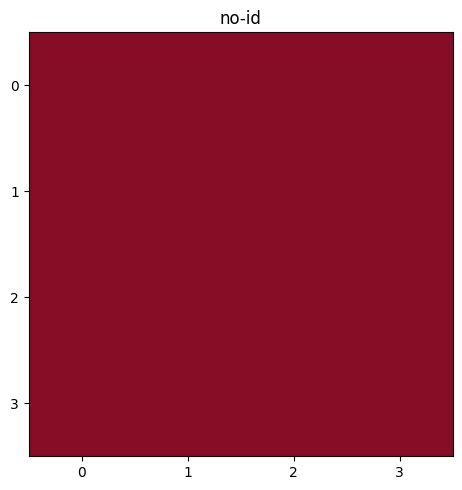

In [131]:

exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        print("x, y", x, y)
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)
        
        my_data = SingleImageDataset(pil_image, transform=test_transforms)
        my_loader = DataLoader(dataset = my_data, batch_size=batch_size, shuffle=True)
        for data, label in my_loader:
            #for data, label in tqdm(my_loader):
            #print(data.shape)
            data = data.to(device)

            output = model(data)
            #print(output)
            output_tensor = output.cpu().detach()
            print(output_tensor)
            output_value = output_tensor.argmax(dim=1)
            #print(output_value)
            #result_pixels
            set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()